##### 1 - Fetch de data

In [6]:
import numpy as np
import requests,gzip,os,hashlib
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Buscamos los datos
# Creamos una funcion que toma los datos, los descomprime y convierte en un numpy array

path='/home/juan/learning_python/data/'
def fetch(url):
    fp = os.path.join(path,hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp,"rb") as f:
            data = f.read()
    else:
        with open(fp,"wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()
# El -1 en el reshape lo que hace es mantener esa dimension como indefinida y ajustar al resto de las dimensiones
X = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [8]:
# Separamos los datos para poder tener un training set y un test set

# Esto lo podriamos tener desde antes?
# Evitar trabajar con random en leo?
rand = np.arange(60000)
np.random.shuffle(rand)
train_no = rand[:50000]

val_no = np.setdiff1d(rand,train_no)

X_train,X_val =X[train_no,:,:],X[val_no,:,:]
Y_train,Y_val =Y[train_no],Y[val_no]

La red neuronal va a ser una sencilla de tres capas/layers.
La primer capa toma los 28*28 (784) provenientes de la imagen y pasa a una de 128.  De ahi viene una matriz de 784x128

Luego la segunda capa toma los 128 y lleva a 10 teniendo asociada una matriz de 128x10

Los 10 valores corresponden a lo que queremos clasificar

In [9]:
# Esto es para inicializar la red, usamos números al azar
# np.random.uniform  nos da valores en una distribucion uniforme
# primer valor es el más bajo, le sigue el más alto y el tamaño lo da x*y
# la raiz cuadrada es para normalizar

def init(x,y):
    layer = np.random.uniform(-1.,1.,size=(x,y))/np.sqrt(x*y)
    return layer.astype(np.float32)

np.random.seed(42)
l1 = init(28*28,128)
l2 = init(128,10)



In [10]:
# La funcion sigmoide la vamos a utilizar para la activacion de la red, actualmente se utilizan otras como ReLu, tanh, etc
# toma valores y devuelve número entre 0 y 1
def sigmoid(x):
    return 1/(np.exp(-x)+1)

# Calculamos la derivada de la funcion sigmoide porque despues vamos a necesitar realizar una regla de la cadena
# entonces vamos a necesitar la derivada de la funcion sigmoide

def d_sigmoid(x):
    return(np.exp(-x)/((np.exp(-x)+1)**2))



In [11]:


# Softmax la necesitamos para la salida de la red, vamos a querer que nos de una probabilidad de que cada uno de los 10 
# elementos, es decir de 0 a 9 
def softmax(x):
    exponents = np.exp(x)
    return exponents/np.sum(exponents)

# Softmax nos devuelve un vector de probabilidades por asi decirlo, el valor será el que mayor sea  
    

In [12]:
# Al utilizar softmax corremos con el peligro de tener un overflow por lo que introducimos
# una modificacion a la misma


def softmax(x):
    exp_element = np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)

# Derivada de softmax modificada

def d_softmax(x):
    exp_element = np.exp(x-x.max())
    return exp_element/np.sum(exp_element,axis=0)*(1-exp_element/np.sum(exp_element,axis=0))

In [13]:
# forward pass y backward pass aka backpropagation

# Recordar que estamos buscando ajustar los weigths y bias de la red


def forward_backward_pass(x,y):
    targets = np.zeros((len(y),10), np.float32)
    targets[range(targets.shape[0]),y] = 1
 # pongo un 1 en la posicion de la clase que corresponde
    
    x_l1=x.dot(l1) # multiplicamos las matrices de las capas
    x_sigmoid=sigmoid(x_l1) # aplico sigmoide
    x_l2=x_sigmoid.dot(l2)
    out=softmax(x_l2)
   

# Error de la funcion costo derivado ya que estamos buscando un minimo

    error=2*(out-targets)/out.shape[0]*d_softmax(x_l2)
 # la derivada nos da una dicea de cuanto cambiamos x_l2
    update_l2=x_sigmoid.T@error
  # @ es multiplicacion matricial
  # .T hace la transpuesta  
    
    error=((l2).dot(error.T)).T*d_sigmoid(x_l1)
    update_l1=x.T@error

    return out,update_l1,update_l2 

In [14]:

# Entrenamos la red neuronal con grandiente estocástico
# Se utiliza estocástico para reducir el tiempo de computo
# separamos en 128 batches o lotes
# Recordatorio,el -1 en el reshape lo que hace es mantener esa dimension como indefinida y ajustar al resto de las dimensiones

epochs=10000 
lr=0.001
batch=128

losses,accuracies,val_accuracies=[],[],[]

for i in range(epochs):
    sample=np.random.randint(0,X_train.shape[0],size=(batch))
    x=X_train[sample].reshape((-1,28*28))
    y=Y_train[sample]
 

    out,update_l1,update_l2=forward_backward_pass(x,y)
  
    category=np.argmax(out,axis=1)
    accuracy=(category==y).mean()
    accuracies.append(accuracy)
    
    loss=((category-y)**2).mean()
    losses.append(loss.item())
    
    l1=l1-lr*update_l1
    l2=l2-lr*update_l2
    
    if(i%20==0):    
        X_val=X_val.reshape((-1,28*28))
        val_out=np.argmax(softmax(sigmoid(X_val.dot(l1)).dot(l2)),axis=1)
        val_acc=(val_out==Y_val).mean()
        val_accuracies.append(val_acc.item())
    if(i%500==0): print(f'For {i}th epoch: train accuracy: {accuracy:.3f} | validation accuracy:{val_acc:.3f}')

For 0th epoch: train accuracy: 0.062 | validation accuracy:0.071
For 500th epoch: train accuracy: 0.625 | validation accuracy:0.653
For 1000th epoch: train accuracy: 0.695 | validation accuracy:0.744
For 1500th epoch: train accuracy: 0.781 | validation accuracy:0.771
For 2000th epoch: train accuracy: 0.820 | validation accuracy:0.784
For 2500th epoch: train accuracy: 0.844 | validation accuracy:0.792
For 3000th epoch: train accuracy: 0.766 | validation accuracy:0.797
For 3500th epoch: train accuracy: 0.773 | validation accuracy:0.804
For 4000th epoch: train accuracy: 0.828 | validation accuracy:0.810
For 4500th epoch: train accuracy: 0.867 | validation accuracy:0.815
For 5000th epoch: train accuracy: 0.781 | validation accuracy:0.819
For 5500th epoch: train accuracy: 0.906 | validation accuracy:0.819
For 6000th epoch: train accuracy: 0.828 | validation accuracy:0.821
For 6500th epoch: train accuracy: 0.797 | validation accuracy:0.823
For 7000th epoch: train accuracy: 0.820 | validation

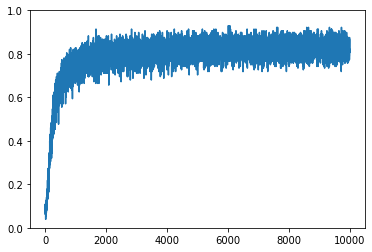

In [15]:
# Veamos los resultados
plt.ylim(-0,1,1.1)
plt.plot(accuracies)

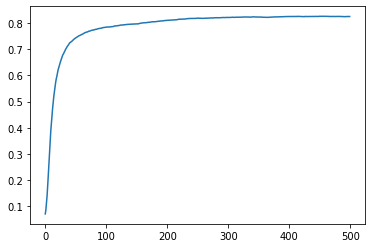

In [16]:
plt.plot(val_accuracies)

array([7])

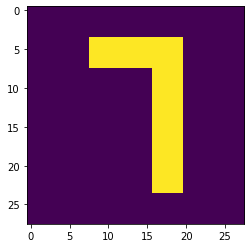

In [21]:
# Creo un ejemplo de juguete que se deria ver como un 7

m = [[0,0,0,0,0,0,0],
     [0,0,10,10,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,10,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
m=m.reshape(1,-1)
plt.imshow(m.reshape(28,28))
x = np.argmax(sigmoid(m.dot(l1)).dot(l2),axis=1)
x


array([1])

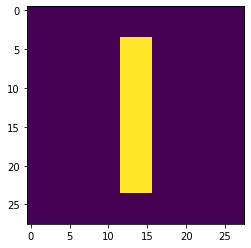

In [22]:
# Esto deberia verse como un 1

n = [[0,0,0,0,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,10,0,0,0],
     [0,0,0,0,0,0,0]]

n = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in n])
n=n.reshape(1,-1)
plt.imshow(n.reshape(28,28))
x = np.argmax(sigmoid(n.dot(l1)).dot(l2),axis=1)
x

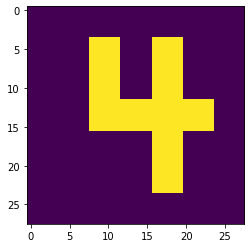

In [27]:
# Esto deberia ser un 4



l = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
l= np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in l])
plt.imshow(l.reshape(28,28))



In [26]:
x = l.reshape(1, -1).dot(l1)
x = np.maximum(x, 0)
x = x.dot(l2)
np.argmax(x)

4